<a href="https://colab.research.google.com/github/aycaaozturk/Nail-Melanoma-Project/blob/main/YOLO_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics scikit-learn matplotlib --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 59.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

import os, glob, sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score, f1_score
)

from ultralytics import YOLO


np.set_printoptions(linewidth=140, suppress=True)



# Paths & hyperparameters

# change this for your dataset
DATA_ROOT = "/content/drive/My Drive/yolov8 format all datasets/nail_dataset/"

#DATA_ROOT = "/content/drive/My Drive/binary classification"


IMG_SIZE   = 224
BATCH_SIZE = 32
EPOCHS     = 10
PROJECT    = "nails_cls"   # Ultralytics "project" folder
RUN_NAME   = "effort301"     # subfolder for this run, change its number when you run the code


# Detect splits
TRAIN_DIR = os.path.join(DATA_ROOT, "train")
VAL_DIR   = os.path.join(DATA_ROOT, "val") if os.path.isdir(os.path.join(DATA_ROOT, "val")) else \
            os.path.join(DATA_ROOT, "valid") if os.path.isdir(os.path.join(DATA_ROOT, "valid")) else \
            os.path.join(DATA_ROOT, "test")   # fallback if only "test" exists
TEST_DIR  = os.path.join(DATA_ROOT, "test") if os.path.isdir(os.path.join(DATA_ROOT, "test")) else None

for d in [TRAIN_DIR, VAL_DIR]:
    if not os.path.isdir(d):
        raise FileNotFoundError(f"Expected split not found: {d}")




Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# Train YOLOv8 classifier
# Use an ImageNet-pretrained YOLOv8 classifier backbone

# classifier: n stands for nano
clf = YOLO("yolov8n-cls.pt")


# train the model
clf.train(
    data=DATA_ROOT,     # root containing train/ val/
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    lr0=1e-3,
    project=PROJECT,
    name=RUN_NAME,
    verbose=True         # to print the outcomes

    )




Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/My Drive/yolov8 format all datasets/nail_dataset/, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=effort301, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pat

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ae8368b1f70>
curves: []
curves_results: []
fitness: 0.987089216709137
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9741784334182739, 'metrics/accuracy_top5': 1.0, 'fitness': 0.987089216709137}
save_dir: PosixPath('/content/nails_cls/effort301')
speed: {'preprocess': 0.1350550492945348, 'inference': 0.4044810539908682, 'loss': 0.00020896478906760134, 'postprocess': 0.00028586150235664526}
task: 'classify'
top1: 0.9741784334182739
top5: 1.0

In [5]:
best_model = clf
BEST_WEIGHTS = os.path.join("content", "nails_cls", RUN_NAME, "weights", "best.pt")   # loads the best model (highest val score)

In [6]:
# Helper: list images & labels from a split

# returns the file paths and labels to use for the evaluation metrics

def list_images_and_labels(split_dir):
    """Return (filepaths, labels, class_to_idx, idx_to_class) with classes sorted alphabetically."""
    classes = [d for d in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, d))]
    classes = sorted(classes)  # YOLO uses alphabetical mapping 0..C-1
    class_to_idx = {c: i for i, c in enumerate(classes)}
    idx_to_class = {i: c for c, i in class_to_idx.items()}

    exts = ("*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp")
    filepaths, labels = [], []
    for cls in classes:
        cls_dir = os.path.join(split_dir, cls)
        files = []
        for e in exts:
            files.extend(glob.glob(os.path.join(cls_dir, e)))
        files = sorted(files)
        filepaths.extend(files)
        labels.extend([class_to_idx[cls]] * len(files))

    if len(filepaths) == 0:
        raise RuntimeError(f"No images found under {split_dir}. Check your folder structure.")

    return filepaths, np.array(labels, dtype=int), class_to_idx, idx_to_class


In [7]:
# Evaluate on VAL (or TEST) split with rich metrics

# for evaluation -> with the model predictions

EVAL_DIR = TEST_DIR if TEST_DIR else VAL_DIR
eval_name = "TEST" if TEST_DIR else "VAL"
print(f"[Info] Evaluating on {eval_name} split → {EVAL_DIR}")

filepaths, y_true, class_to_idx, idx_to_class = list_images_and_labels(EVAL_DIR)
classes = [idx_to_class[i] for i in range(len(idx_to_class))]
print("Class mapping:", class_to_idx)

# Batch prediction
# For classification, result.probs contains scores per class.
results = best_model.predict(
    source=filepaths,
    imgsz=IMG_SIZE,
    verbose=False
)

# Collect probabilities and predicted labels
num_classes = len(classes)
probs = np.vstack([r.probs.data.cpu().numpy() for r in results])   # shape: [N, C]
y_pred = probs.argmax(axis=1)

[Info] Evaluating on TEST split → /content/drive/My Drive/yolov8 format all datasets/nail_dataset/test
Class mapping: {'healthy': 0, 'melanoma': 1, 'other': 2}


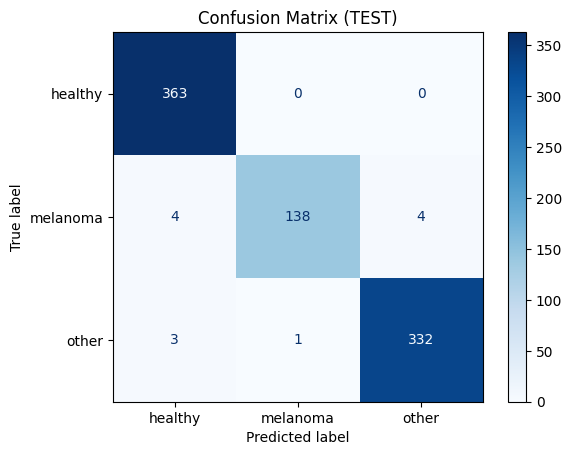

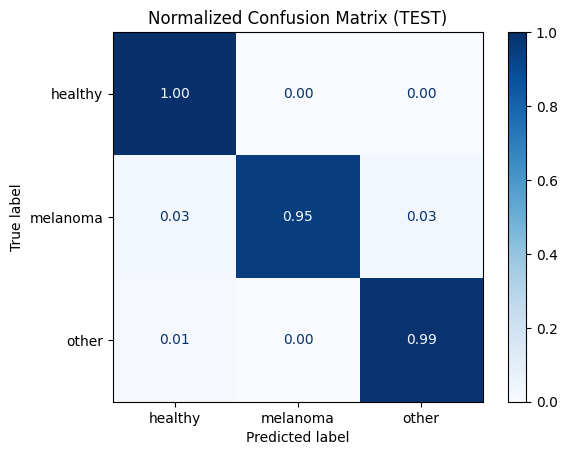


Classification report:
              precision    recall  f1-score   support

     healthy      0.981     1.000     0.990       363
    melanoma      0.993     0.945     0.968       146
       other      0.988     0.988     0.988       336

    accuracy                          0.986       845
   macro avg      0.987     0.978     0.982       845
weighted avg      0.986     0.986     0.986       845



In [8]:
#Confusion matrix (counts + normalized)

cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
ConfusionMatrixDisplay(cm, display_labels=classes).plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix ({eval_name})")
plt.show()

cm_norm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)), normalize="true")
ConfusionMatrixDisplay(cm_norm, display_labels=classes).plot(cmap="Blues", values_format=".2f")
plt.title(f"Normalized Confusion Matrix ({eval_name})")
plt.show()

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=classes, digits=3))


In [9]:
#ROC and PR curves

if num_classes == 2:
    # Choose which class is "positive" (e.g., Melanoma).
    # We'll assume 'Melanoma' exists in classes; otherwise set positive_idx=1.
    positive_class_name = "Melanoma" if "Melanoma" in class_to_idx else classes[1]
    positive_idx = class_to_idx[positive_class_name]

    y_score = probs[:, positive_idx]  # probability of positive class
    y_bin   = (y_true == positive_idx).astype(int)

    # ROC
    fpr, tpr, _ = roc_curve(y_bin, y_score)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0,1], [0,1], "--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title(f"ROC Curve ({eval_name}) — Positive: {positive_class_name}")
    plt.legend(); plt.show()

    # Precision-Recall
    prec, rec, _ = precision_recall_curve(y_bin, y_score)
    ap = average_precision_score(y_bin, y_score)
    plt.figure(figsize=(5,5))
    plt.plot(rec, prec, label=f"AP = {ap:.3f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision–Recall ({eval_name}) — Positive: {positive_class_name}")
    plt.legend(); plt.show()

In [10]:

#Find results.csv of this run

import pandas as pd
import glob, os

# Ultralytics saves here because you passed project/name
RUN_DIR = f"/content/{PROJECT}/{RUN_NAME}"
if not os.path.isdir(RUN_DIR):                   # in case Ultralytics renamed to expN
    candidates = sorted(glob.glob(f"/content/{PROJECT}/**", recursive=True), key=os.path.getmtime)
    candidates = [d for d in candidates if os.path.isdir(d)]
    RUN_DIR = candidates[-1]                      # latest folder

csv_path = os.path.join(RUN_DIR, "results.csv")
if not os.path.isfile(csv_path):
    raise FileNotFoundError(f"results.csv not found under {RUN_DIR}")

df = pd.read_csv(csv_path)
print("columns:", list(df.columns))


columns: ['epoch', 'time', 'train/loss', 'metrics/accuracy_top1', 'metrics/accuracy_top5', 'val/loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


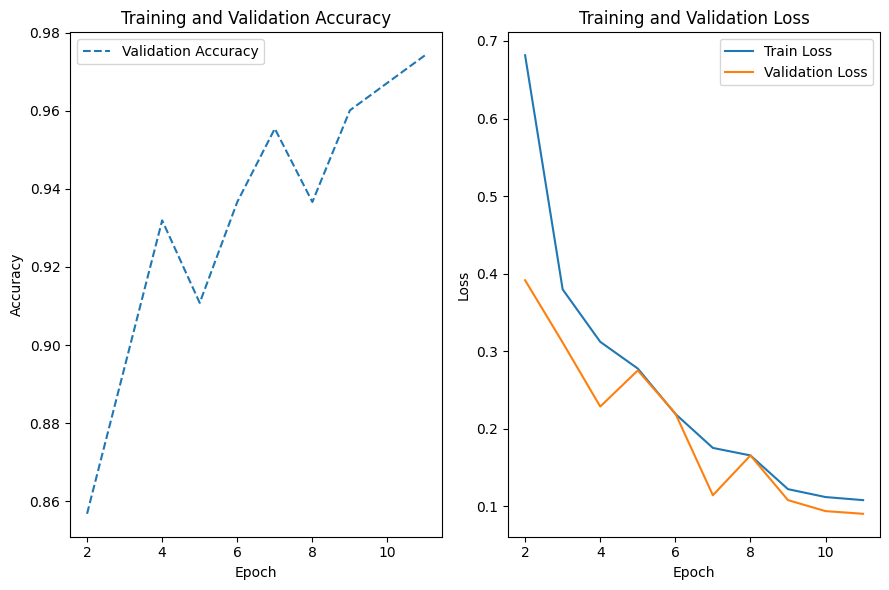

In [11]:

# Plot Training vs Validation Accuracy/Loss

import matplotlib.pyplot as plt

epochs = df["epoch"].values + 1  # make epochs 1-based for the x-axis

#column names for Ultralytics cls:
acc_col   = "metrics/accuracy_top1"  # top-1 accuracy
tr_loss   = "train/loss"
val_loss  = "val/loss"

plt.figure(figsize=(9,6))

#  Accuracy
plt.subplot(1,2,1)

# Ultralytics logs only one accuracy column (computed on val set each epoch).

plt.plot(epochs, df[acc_col], linestyle="--", label="Validation Accuracy")  # same as above
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(epochs, df[tr_loss], label="Train Loss")
plt.plot(epochs, df[val_loss], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
def classify_single_image(image_path, model, idx_to_class, img_size=IMG_SIZE):



    # YOLO's prediction
    result = model.predict(source=image_path, imgsz=img_size, verbose=False)[0]

    # take the probabilities
    probs = result.probs.data.cpu().numpy()  # shape: [C]
    pred_idx = probs.argmax()
    pred_class = idx_to_class[pred_idx]
    pred_prob = probs[pred_idx]

    print(f"Image: {image_path}")
    print(f"Predicted class: {pred_class} (prob: {pred_prob:.3f})")
    print("\nAll class probabilities:")
    for i, cls_name in idx_to_class.items():
        print(f"  {i} - {cls_name}: {probs[i]:.3f}")

In [14]:
single_image_path = "/content/drive/My Drive/models best/nail_pic.jpg"

classify_single_image(
    image_path=single_image_path,
    model=best_model,
    idx_to_class=idx_to_class,
    img_size=IMG_SIZE
)

Image: /content/drive/My Drive/models best/nail_pic.jpg
Predicted class: melanoma (prob: 1.000)

All class probabilities:
  0 - healthy: 0.000
  1 - melanoma: 1.000
  2 - other: 0.000
